In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

exec(open("functions.py").read())

trivial PR_T

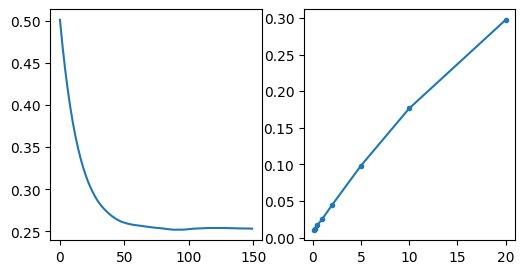

In [2]:
#trajectory
key = jrandom.PRNGKey(0)
part_n = 100
flip_n = 200
x_resolution = 30
flip_interval_s = jrandom.exponential(key, shape=(part_n, flip_n));
acov_traj_len = jnp.min(jnp.sum(jnp.round(flip_interval_s * x_resolution).astype(int), axis = -1))
traj = jnp.concatenate([jnp.concatenate([jnp.full((1, 
                                     jnp.round(flip_interval_s[part_idx, flip_idx]* x_resolution).astype(int)), flip_idx%2)
                           for flip_idx in range(flip_n)], axis = -1)[:, :acov_traj_len]
          for part_idx in range(part_n)])

#stats
[fig, subfig_s] = plt.subplots(1, 2, figsize = (6,3), squeeze = False)
subfig_s[0, 0].plot(jnp.mean(matched_correlation_fct(traj, traj, 0, 0), axis = 0)[:30*5])
window_len_s = jnp.asarray([0.1, 0.2,0.5,1,2,5,10,20])
samp_separation_with_n=samp_separation_with_n_fct(window_len_s, x_resolution)
kernel_s=kernel_s_fct(window_len_s, x_resolution, jnp.inf, 0.98)
multi_len_pr_tr_os_s=multi_len_pr_tr_os_s_fct(traj, x_resolution,
                             kernel_s, samp_separation_with_n)
subfig_s[0, 1].plot(window_len_s,
         jnp.mean(multi_len_pr_tr_os_s[0], axis = 1)[:-1], marker = '.')

h_acov

In [3]:
def num_primitive_fct(num_function, baseline_idx, x_resolution):
  sum_left = jnp.cumsum(num_function, axis = -1) / x_resolution
  sum_right = jnp.cumsum(-num_function[..., ::-1], axis = -1)[..., ::-1] / x_resolution
  mean_sum = (sum_left + sum_right) / 2
  return(mean_sum - mean_sum[..., baseline_idx:(baseline_idx + 1)])

def num_integral_fct(num_function, x_resolution):
  sum_left = jnp.sum(num_function[..., :-1], axis = -1) / x_resolution
  sum_right = jnp.sum(num_function[..., 1:], axis = -1) / x_resolution
  return((sum_left + sum_right) / 2)

In [4]:
interval_len = 10
long_interval_len = 10 * interval_len
x_resolution = 100#300

zero_idx = int(interval_len / 2 * x_resolution)
x_idx_s = jnp.arange(interval_len * x_resolution)
x_s = x_idx_s / x_resolution - interval_len / 2

std_gau_s = 1/jnp.sqrt(2*jnp.pi) * jnp.exp(- x_s ** 2 /2)
def std_gau_fct(x):
  return(jnp.interp(x, x_s, std_gau_s, left = "extrapolate", right = "extrapolate"))
tanh_itg_s = num_primitive_fct(jnp.tanh(x_s), zero_idx, x_resolution)
def tanh_itg_fct(x):
  return(jnp.interp(x, x_s, tanh_itg_s, left = "extrapolate", right = "extrapolate"))

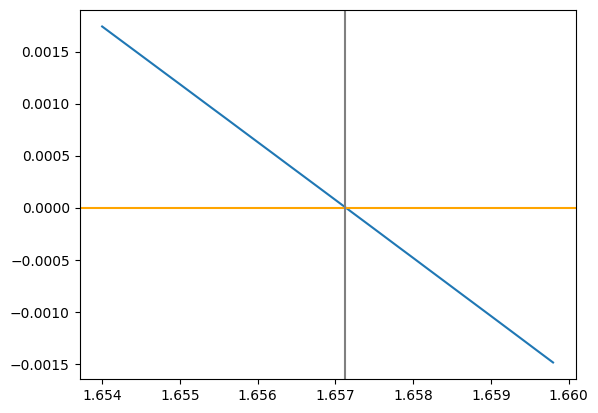

In [5]:
# determine stable init_h_acov
unscaled_std = 1.9

# # g phi
# init_h_acov_s_interval = jnp.asarray([0.458,0.460])
# init_h_acov_s = init_h_acov_s_interval[0]+jnp.arange(30)/30*(init_h_acov_s_interval[1]-init_h_acov_s_interval[0])
# init_potential_s = (-(init_h_acov_s ** 2 / 2)
#  +num_integral_fct(tanh_itg_fct(unscaled_std * x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1))) **2
#                                * std_gau_fct(x_s), 
#                                      x_resolution) / unscaled_std ** 2 
#  -num_integral_fct(tanh_itg_fct(unscaled_std * x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1)))
#                                * std_gau_fct(x_s), 
#                                      x_resolution) **2 / unscaled_std ** 2)
# init_h_acov = 0.45903

# phi(gh)
init_h_acov_s_interval = jnp.asarray([1.654,1.66])
init_h_acov_s = init_h_acov_s_interval[0]+jnp.arange(30)/30*(init_h_acov_s_interval[1]-init_h_acov_s_interval[0])
init_potential_s = (-(init_h_acov_s ** 2 / 2)
 +num_integral_fct(tanh_itg_fct(x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1))) **2
                               * std_gau_fct(x_s), 
                                     x_resolution) * unscaled_std ** 2 
 -num_integral_fct(tanh_itg_fct(x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1)))
                               * std_gau_fct(x_s), 
                                     x_resolution) **2 * unscaled_std ** 2)
init_h_acov = 1.65712

plt.plot(init_h_acov_s, init_potential_s)
plt.axhline(y = 0, color = 'orange')
plt.axvline(x = init_h_acov, color = 'gray')

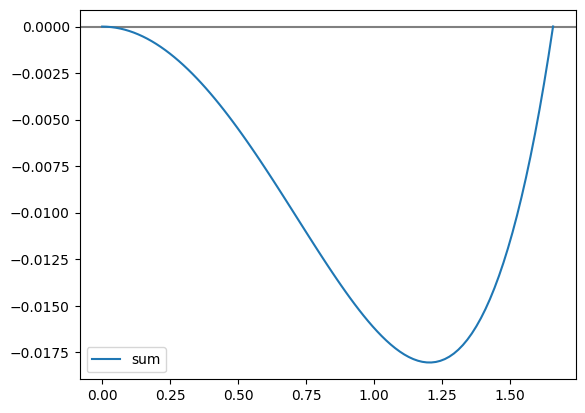

In [6]:
h_acov_step_n = x_resolution#100

h_acov_idx_s = jnp.arange(h_acov_step_n + 1)
h_acov_s = h_acov_idx_s / h_acov_step_n * init_h_acov

# # phi(g h)
# potential_s_1 = -(h_acov_s ** 2 / 2)
# potential_s_2 = num_integral_fct(
#     num_integral_fct(tanh_itg_fct(unscaled_std * jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
#                                   + unscaled_std * jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
#                  * jnp.expand_dims(std_gau_fct(x_s), (0, 1)), 
#                  x_resolution) ** 2
#     * jnp.expand_dims(std_gau_fct(x_s), 0),
#     x_resolution) / unscaled_std ** 2
# potential_s_3 = -num_integral_fct(tanh_itg_fct(unscaled_std * x_s * jnp.sqrt(init_h_acov))
#                                * std_gau_fct(x_s), 
#                                      x_resolution) **2 / unscaled_std ** 2

# g phi(h)
potential_s_1 = -(h_acov_s ** 2 / 2)
potential_s_2 = num_integral_fct(
    num_integral_fct(tanh_itg_fct(jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
                                        + jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
                 * jnp.expand_dims(std_gau_fct(x_s), (0, 1)), 
                 x_resolution) ** 2
    * jnp.expand_dims(std_gau_fct(x_s), 0),
    x_resolution) * unscaled_std ** 2
potential_s_3 = -num_integral_fct(tanh_itg_fct(x_s * jnp.sqrt(init_h_acov))
                               * std_gau_fct(x_s), 
                                     x_resolution) **2 * unscaled_std ** 2

potential_s = potential_s_1 + potential_s_2 + potential_s_3
potential_s = potential_s - potential_s[0]
plt.axhline(y = 0, color = 'gray')
#plt.plot(h_acov_s, potential_s_1, label = "^2")
#plt.plot(h_acov_s, potential_s_2, label = "itg")
#plt.plot(h_acov_s, jnp.full(h_acov_s.shape, potential_s_3), label = "c")
plt.plot(h_acov_s, potential_s, label = "sum")
plt.legend()

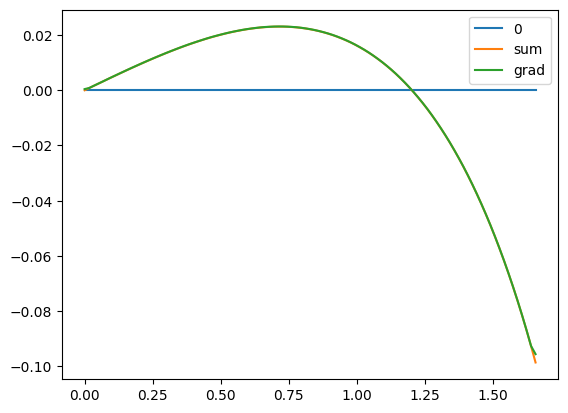

In [7]:
# # phi(g h)
# force_s_1 = h_acov_s 
# force_s_2 = -num_integral_fct(
#     num_integral_fct(jnp.tanh(unscaled_std * jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
#                               + unscaled_std * jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
#                  * jnp.expand_dims(std_gau_fct(x_s), (0, 1)), 
#                  x_resolution) ** 2
#     * jnp.expand_dims(std_gau_fct(x_s), 0),
#     x_resolution)

# g phi(h)
force_s_1 = h_acov_s 
force_s_2 = -num_integral_fct(
    num_integral_fct(jnp.tanh(jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
                                        + jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
                 * jnp.expand_dims(std_gau_fct(x_s), (0, 1)), 
                 x_resolution) ** 2
    * jnp.expand_dims(std_gau_fct(x_s), 0),
    x_resolution) * unscaled_std ** 2

force_s = force_s_1 + force_s_2

plt.plot(h_acov_s, jnp.full(h_acov_s.shape, 0), label = "0")
# plt.plot(h_acov_s, force_s_2, label = "sum")
plt.plot(h_acov_s, force_s, label = "sum")
plt.plot(h_acov_s, -jnp.gradient(potential_s) * h_acov_step_n/init_h_acov, label = "grad")
plt.legend()

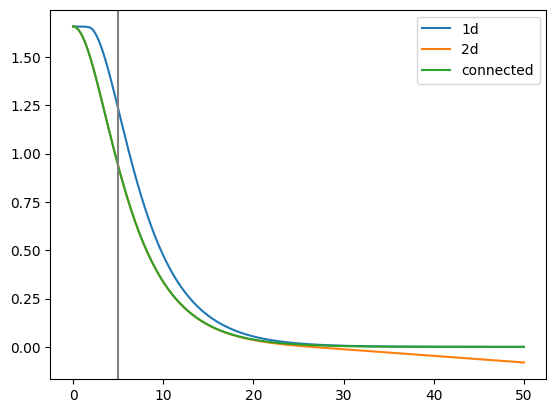

In [8]:
sim_len = 50
sim_resolution = 40

acov_lag_s = jnp.arange(sim_len * sim_resolution + 1)/sim_resolution

# separate 1d/2d
sim_interval = jnp.asarray([0,sim_len])

def h_acov_1d_velocity_fct(h_acov):
  return(jnp.interp(h_acov, h_acov_s, -jnp.sqrt(jnp.maximum(-2*potential_s, 0)), 
                    left = 0, right = "extrapolate"))
h_acov_traj_1d = traj_initializer(jnp.asarray(init_h_acov-0.00001), sim_interval, sim_resolution)
h_acov_traj_1d = jnp.insert(rk4_ode_solver(h_acov_1d_velocity_fct, lambda time: 0, h_acov_traj_1d, sim_interval, sim_resolution), 
                          0, init_h_acov)
plt.plot(acov_lag_s, h_acov_traj_1d, label = "1d")

def h_acov_2d_velocity_fct(pos_vel):
  return(jnp.asarray([pos_vel[1], jnp.interp(pos_vel[0], h_acov_s,-jnp.gradient(potential_s) * h_acov_step_n/init_h_acov, 
                                             left = 0, right = "extrapolate")]))
h_acov_traj_2d = traj_initializer(jnp.asarray([init_h_acov, 0]), sim_interval, sim_resolution)
h_acov_traj_2d = jnp.insert(rk4_ode_solver(h_acov_2d_velocity_fct, lambda time: 0, h_acov_traj_2d, sim_interval, sim_resolution),
                          0, jnp.asarray([init_h_acov, 0]), axis = 1)
plt.plot(acov_lag_s, h_acov_traj_2d[0], label = "2d")

plt.legend()

# connected
connection_pos = 5

sim_interval_2d = jnp.asarray([0, connection_pos])
sim_interval_1d = jnp.asarray([connection_pos, sim_len])
def h_acov_2d_velocity_fct(pos_vel):
  return(jnp.asarray([pos_vel[1], jnp.interp(pos_vel[0], h_acov_s,-jnp.gradient(potential_s) * h_acov_step_n/init_h_acov, 
                                             left = 0, right = "extrapolate")]))
def h_acov_1d_velocity_fct(h_acov):
  return(jnp.interp(h_acov, h_acov_s, -jnp.sqrt(jnp.maximum(-2*potential_s, 0)), 
                    left = 0, right = "extrapolate"))
h_acov_traj_c_2d = traj_initializer(jnp.asarray([init_h_acov, 0]), sim_interval_2d, sim_resolution)
h_acov_traj_c_2d = rk4_ode_solver(h_acov_2d_velocity_fct, lambda time: 0, h_acov_traj_c_2d, sim_interval, sim_resolution)
h_acov_traj_c_1d = traj_initializer(jnp.asarray(h_acov_traj_c_2d[0,-1]), sim_interval_1d, sim_resolution)
h_acov_traj_c_1d = rk4_ode_solver(h_acov_1d_velocity_fct, lambda time: 0, h_acov_traj_c_1d, sim_interval, sim_resolution)
h_acov_traj_c = jnp.concatenate([jnp.asarray([init_h_acov]), h_acov_traj_c_2d[0], h_acov_traj_c_1d])
plt.plot(acov_lag_s, 
         h_acov_traj_c, label = "connected")
plt.axvline(x = connection_pos, color = 'gray')
plt.legend()

ft and ccov

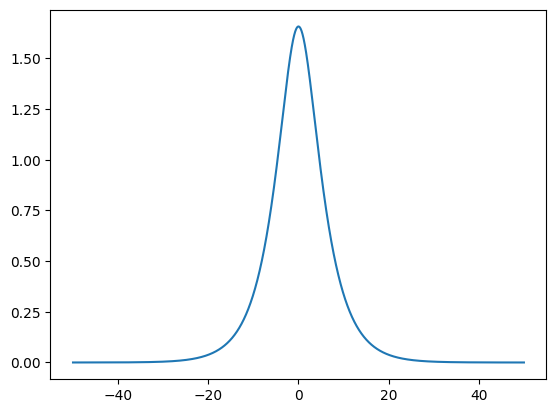

In [9]:
def mirror(traj, transformation = lambda x:x):
  return(jnp.concatenate([transformation(traj[..., 1:][..., ::-1]), 
                          traj], axis = -1))

h_acov_traj_full = mirror(h_acov_traj_c)
acov_lag_s_full = mirror(acov_lag_s, lambda x:-x)
plt.plot(acov_lag_s_full, h_acov_traj_full)

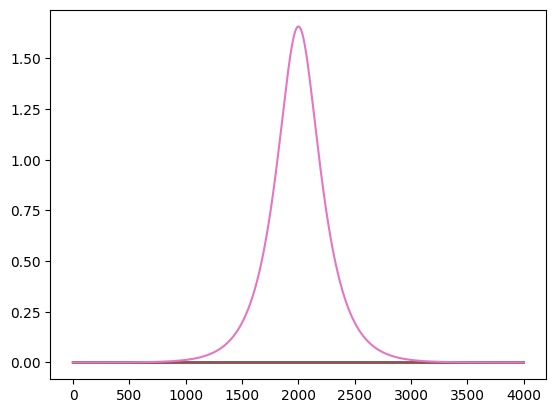

In [10]:
#negative frequencies, ft vs rft
def rft_mirror(rft, n=1):
  if n%2 ==1:
    output=jnp.concatenate([rft, jnp.conjugate(rft[::-1][:-1])], axis = -1)
  else:
    output=jnp.concatenate([rft, jnp.conjugate(rft[::-1][1:-1])], axis = -1)
  return(output)

#odd
odd_ft_n = sim_len * sim_resolution * 2 + 1
h_acov_traj_ft=jnp.fft.fft(h_acov_traj_full)
h_acov_traj_rft=jnp.fft.rfft(h_acov_traj_full)
h_acov_traj_rft_mirror=rft_mirror(h_acov_traj_rft)
ft_error = h_acov_traj_rft_mirror-h_acov_traj_ft
plt.plot(jnp.real(ft_error))
plt.plot(jnp.imag(ft_error))

h_acov_traj_ft_rec=jnp.fft.ifft(h_acov_traj_ft)
h_acov_traj_rft_rec=jnp.fft.irfft(h_acov_traj_rft,n=odd_ft_n) #irfft assumes even n
h_acov_traj_rft_mirror_rec=jnp.fft.ifft(h_acov_traj_rft_mirror)
plt.plot(jnp.real(h_acov_traj_ft_rec-h_acov_traj_full))
plt.plot(jnp.real(h_acov_traj_rft_rec-h_acov_traj_full))
plt.plot(jnp.real(h_acov_traj_rft_mirror_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_ft_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_rft_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_rft_mirror_rec-h_acov_traj_full))

#even
even_ft_n = sim_len * sim_resolution * 2 + 2
h_acov_traj_ft=jnp.fft.fft(h_acov_traj_full, n = even_ft_n)
h_acov_traj_rft=jnp.fft.rfft(h_acov_traj_full, n = even_ft_n)
h_acov_traj_rft_mirror=rft_mirror(h_acov_traj_rft,2)
ft_error = h_acov_traj_rft_mirror-h_acov_traj_ft
plt.plot(jnp.real(ft_error))
plt.plot(jnp.imag(ft_error))

h_acov_traj_ft_rec=jnp.fft.ifft(h_acov_traj_ft)[:-1]
h_acov_traj_rft_rec=jnp.fft.irfft(h_acov_traj_rft)[:-1]
h_acov_traj_rft_mirror_rec=jnp.fft.ifft(h_acov_traj_rft_mirror)[:-1]
plt.plot(jnp.real(h_acov_traj_ft_rec-h_acov_traj_full))
plt.plot(jnp.real(h_acov_traj_rft_rec-h_acov_traj_full))
plt.plot(jnp.real(h_acov_traj_rft_mirror_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_ft_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_rft_rec-h_acov_traj_full))
plt.plot(jnp.imag(h_acov_traj_rft_mirror_rec-h_acov_traj_full))

#curve
plt.plot(h_acov_traj_full)

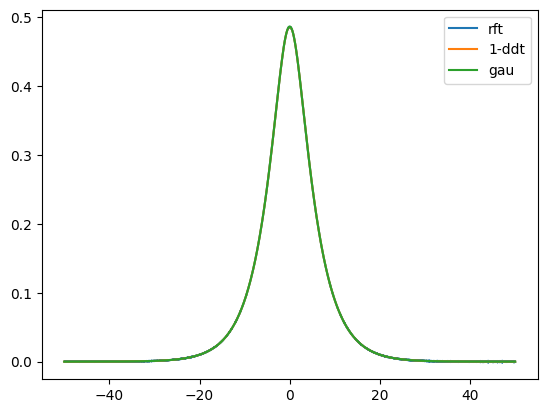

In [11]:
# r_acov
ft_n = sim_len * sim_resolution * 2 + 1
rft_n = jnp.ceil((ft_n + 1)/2).astype(int)
plt.plot(acov_lag_s_full, jnp.fft.irfft(jnp.fft.rfft(h_acov_traj_full) 
                                   * (1+ (2 * jnp.pi * jnp.arange(rft_n)  / (2*sim_len))**2) 
                                   / unscaled_std ** 2, n=ft_n), label = "rft")
# plt.plot(acov_lag_s_full, jnp.fft.irfft(jnp.fft.fft(h_acov_traj_full) 
#                                    * (1+ (jnp.arange(ft_n) * 2 * jnp.pi  / (2*sim_len))**2) 
#                                    / unscaled_std ** 2, n=ft_n), label = "ft")
plt.plot(acov_lag_s_full, (h_acov_traj_full - jnp.gradient(jnp.gradient(h_acov_traj_full)) * sim_resolution **2)
                                   / unscaled_std ** 2, label = "1-ddt")
plt.plot(acov_lag_s_full, jnp.interp(h_acov_traj_full, h_acov_s, -force_s_2 / unscaled_std ** 2, left = 0), label="gau")

# # only positive tau
# ft_n = sim_len * sim_resolution + 1
# rft_n = jnp.ceil((ft_n + 1)/2).astype(int)
# plt.plot(acov_lag_s, jnp.fft.irfft(jnp.fft.rfft(h_acov_traj_c) 
#                                    * (1+ (jnp.arange(rft_n) * 2 * jnp.pi / (sim_len))**2) 
#                                    / unscaled_std ** 2, n=ft_n), label = "half rft")

plt.legend()

r_acov_traj_full = jnp.fft.irfft(jnp.fft.rfft(h_acov_traj_full) 
                                   * (1+ (2 * jnp.pi * jnp.arange(rft_n)  / (2*sim_len))**2) 
                                   / unscaled_std ** 2, n=ft_n)

In [ ]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("../functions.py").read())

In [ ]:
# set basic parameters and subdirectory
part_n = 2000
e_part_r = 0.8
e_mean = 4
ei_std_s = [4, 4]
waiting_time = 300
interval_len = 900
freq = 0.1
subdirectory = ("{:n}_".format(part_n)
                + "{:n}_".format(e_part_r)
                + "{:n}_".format(e_mean)
                + "{0:n}-{1:n}/".format(ei_std_s[0],
                                        ei_std_s[1]))
Path(subdirectory).mkdir()
print(ei_spectral_radius_fct(e_part_r, ei_std_s))

seed = 1697056482#1696966015#round(time.time())
subdirectory = (subdirectory + "{:n}_".format(seed)
                + "{0:n}-{1:n}_".format(interval_len, 
                                        waiting_time)
                + "{:n}/".format(freq))
Path(subdirectory).mkdir()
print(subdirectory)

In [ ]:
# generate and save parameters for simulation
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.asarray([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean)
unscaled_std = jnp.tile(jnp.asarray([ei_std_s]), (2, 1))
connectivity_n = 1#5
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(connectivity_s_generator(sub_part_n_s,
                                                                             unscaled_mean, unscaled_std,
                                                                             connectivity_n,
                                                                             key),
                                                    sub_part_n_s, in_r, rewiring_prob)
jnp.savez(subdirectory + "parameter_s_1.npz",
          sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
          connectivity_n,
          in_r, rewiring_prob,
          connectivity_s)

sub_part_n_s_ext_gen = jnp.asarray([part_n])
ext_part_n = 1 #part_n // 100
ext_sub_part_r_s = jnp.asarray([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.asarray([[0.]])
unscaled_ext_std = jnp.asarray([[1.]])
ext_connectivity_n = 10 #4 * 4
unique_angle_n = jnp.floor(ext_connectivity_n / 2 + 1).astype(int)
[ext_connectivity_s, key] = ext_connectivity_s_generator(sub_part_n_s_ext_gen, ext_sub_part_n_s,
                                                         unscaled_ext_mean, unscaled_ext_std,
                                                         2,
                                                         key)
angle_s = 0.8+0.2*jnp.arccos((jnp.arange(ext_connectivity_n)+1)/ext_connectivity_n)[::-1]
#jnp.arange(ext_connectivity_n)/ext_connectivity_n * jnp.pi/3
#jnp.arange(ext_connectivity_n) * (2 * jnp.pi / ext_connectivity_n)
ext_connectivity_s = ext_connectivity_s_rotator(ext_connectivity_s, angle_s,
                               sub_part_n_s_ext_gen, ext_sub_part_n_s,
                               unscaled_ext_mean, unscaled_ext_std)
jnp.savez(subdirectory + "parameter_s_2.npz",
          sub_part_n_s_ext_gen, 
          ext_part_n, ext_sub_part_r_s,
          ext_sub_part_n_s,
          unscaled_ext_mean, unscaled_ext_std, 
          ext_connectivity_n,
          angle_s, unique_angle_n,
          ext_connectivity_s)

phase_n = 1#2
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
jnp.savez(subdirectory + "parameter_s_3.npz",
          phase_n,
          phase_s)

amp_s = jnp.expand_dims(jnp.asarray([0.2, 0.5, 1., 8., 12.]), 
                        # or (wave_n, ext_part_n) array so different ext parts have different amps
                        1)
freq_s = jnp.full(amp_s.shape, freq)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]
jnp.savez(subdirectory + "parameter_s_4.npz",
          amp_s, freq_s,
          wave_s,
          wave_n)

init_condition_n = 5
ext_condition_n = ext_connectivity_n * phase_n
init_condition_n_free = init_condition_n * ext_condition_n
[init_condition_s, key] = init_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           init_condition_n_free, key)
jnp.savez(subdirectory + "parameter_s_5.npz",
          init_condition_n,
          ext_condition_n, init_condition_n_free,
          init_condition_s)

label_s = jnp.asarray([1])
label_s_free = jnp.asarray([0])
time_interval_s = jnp.asarray([[0, interval_len]])
jnp.savez(subdirectory + "parameter_s_6.npz",
          label_s, label_s_free,
          time_interval_s)
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

x_resolution = 24
jnp.savez(subdirectory + "parameter_s_7.npz",
          x_resolution)

condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.asarray([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])

In [ ]:
# load parameters
[sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
 connectivity_n,
 in_r, rewiring_prob,
 connectivity_s] = load_as_list(subdirectory + "parameter_s_1.npz")

[sub_part_n_s_ext_gen, 
 ext_part_n, ext_sub_part_r_s,
 ext_sub_part_n_s,
 unscaled_ext_mean, unscaled_ext_std, 
 ext_connectivity_n, 
 angle_s, unique_angle_n,
 ext_connectivity_s] = load_as_list(subdirectory + "parameter_s_2.npz")

[phase_n,
 phase_s] = load_as_list(subdirectory + "parameter_s_3.npz")

[amp_s, freq_s,
 wave_s,
 wave_n] = load_as_list(subdirectory + "parameter_s_4.npz")

[init_condition_n,
 ext_condition_n, init_condition_n_free,
 init_condition_s] = load_as_list(subdirectory + "parameter_s_5.npz")

[label_s, label_s_free,
 time_interval_s] = load_as_list(subdirectory + "parameter_s_6.npz")
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

[x_resolution] = load_as_list(subdirectory + "parameter_s_7.npz")

condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.asarray([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])

In [ ]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n), squeeze = False)
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[0, connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[0, connectivity_idx].set_aspect('equal')

ei balance

In [ ]:
samp_traj = jnp.tanh(rk4_ode_solver(
      lambda position:
      almlin_velocity_fct(connectivity_s[0], position),
      lambda time:
      sin_ext_input_fct(
        wave_s[0], ext_connectivity_s[0], phase_s[0],
        labeled_time_interval_s, time),
      h_acov_traj_initializer(init_condition_s[0], time_interval_s[0], x_resolution).at[..., 0].set(init_condition_s[0]),
      time_interval_s[0], x_resolution))

In [ ]:
pop_mean = (jnp.asarray([jnp.repeat(unscaled_mean[0], sub_part_n_s)/jnp.sqrt(part_n)])
          @samp_traj[:,waiting_time*x_resolution:])[0]

[fig, subfig_s] = plt.subplots(1,2, squeeze = False, figsize = (20, 5))
ft_real = jnp.histogram(pop_mean, 30)
subfig_s[0,0].plot(ft_real[1][:-1],ft_real[0])
subfig_s[0,1].plot(pop_mean)

plt.figure()
ft_real = [jnp.histogram((connectivity_s[0][idx:idx+1,:]
          @samp_traj[:,waiting_time*x_resolution:])[0] - pop_mean, 30) for idx in range(part_n)]
for idx in range(part_n):
  plt.plot(ft_real[idx][1][:-1],ft_real[idx][0])

plt.figure()
ft_real = jnp.histogram(jnp.mean(connectivity_s[0]
          @samp_traj[:,waiting_time*x_resolution:], axis = -1), 30)
plt.plot(ft_real[1][:-1],ft_real[0])

In [ ]:
boundary = sub_part_n_s[0]

e_pop_mean = (jnp.asarray([(jnp.repeat(unscaled_mean[0], sub_part_n_s)/jnp.sqrt(part_n))[:boundary]])
          @samp_traj[:boundary,waiting_time*x_resolution:])[0]

[fig, subfig_s] = plt.subplots(1,2, squeeze = False, figsize = (20, 5))
ft_real = jnp.histogram(e_pop_mean, 30, density = True)
subfig_s[0,0].plot(ft_real[1][:-1],ft_real[0])
subfig_s[0,1].plot(e_pop_mean)
subfig_s[0,0].set_ylim((0,0.03))

plt.figure()
ft_real = [jnp.histogram((connectivity_s[0][idx:idx+1,:boundary]
          @samp_traj[:boundary,waiting_time*x_resolution:])[0]-e_pop_mean, 30) for idx in range(part_n)]
for idx in range(part_n):
  plt.plot(ft_real[idx][1][:-1],ft_real[idx][0])

plt.figure()
ft_real = jnp.histogram(jnp.mean(connectivity_s[0][:,:boundary]
          @samp_traj[:boundary,waiting_time*x_resolution:], axis = -1), 30)
plt.plot(ft_real[1][:-1],ft_real[0])

In [ ]:
boundary = sub_part_n_s[0]

i_pop_mean = (jnp.asarray([(jnp.repeat(unscaled_mean[0], sub_part_n_s)/jnp.sqrt(part_n))[boundary:]])
          @samp_traj[boundary:,waiting_time*x_resolution:])[0]

[fig, subfig_s] = plt.subplots(1,2, squeeze = False, figsize = (20, 5))
ft_real = jnp.histogram(i_pop_mean, 30, density = True)
subfig_s[0,0].plot(ft_real[1][:-1],ft_real[0])
subfig_s[0,1].plot(i_pop_mean)
subfig_s[0,0].set_ylim((0,0.03))

plt.figure()
ft_real = [jnp.histogram((connectivity_s[0][idx:idx+1,boundary:]
          @samp_traj[boundary:,waiting_time*x_resolution:])[0]-i_pop_mean, 30) for idx in range(part_n)]
for idx in range(part_n):
  plt.plot(ft_real[idx][1][:-1],ft_real[idx][0])

plt.figure()
ft_real = jnp.histogram(jnp.mean(connectivity_s[0][:,boundary:]
          @samp_traj[boundary:,waiting_time*x_resolution:], axis = -1), 30)
plt.plot(ft_real[1][:-1],ft_real[0])

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(pop_mean)
plt.plot(e_pop_mean)
plt.plot(i_pop_mean)

In [ ]:
jnp.sqrt(part_n)